## Import Modules

In [0]:
import pandas as pd
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

import math
import random
import os
import time

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

### Go to Drive

In [0]:

from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Comp551-Project3")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Files


In [0]:
X_train = pd.read_pickle('./input/train_images.pkl')
X_test = pd.read_pickle('./input/test_images.pkl')
Y_train = pd.read_csv('./input/train_labels.csv')
Y_train = Y_train['Category'][:].values


'''
Removing background noise
'''
for i in range(len(X_train)):
    blur = cv2.medianBlur(X_train[i],1)
    X_train[i] = cv2.inRange(blur, 230, 255)
    
for i in range(len(X_test)):
    blur = cv2.medianBlur(X_test[i],1)
    X_test[i] = cv2.inRange(blur, 230, 255)

### Data Loader

In [0]:
class MNIST_data(Dataset):    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_pickle(file_path)
        
        if len(df) == len(X_test):
            # test data
            self.X = X_test.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = X_train.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
            self.y = Y_train
            
        self.transform = transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Random Rotation Transformation

In [0]:
class RandomRotation(object):
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)
          
        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

### Random Vertical and Horizontal Shift

In [0]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

## Load Data into Tensors

In [0]:
batch_size = 64

train_dataset = MNIST_data('./input/train_images.pkl', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('./input/test_images.pkl')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

### Visualize the Transformations

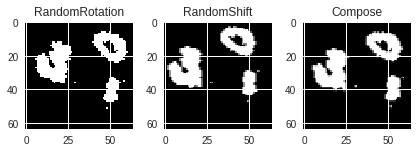

In [0]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(X_train[65].reshape((64,64)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,64)), cmap='gray')    

plt.show()

## Neural Network

In [0]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
       
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 16 * 16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [0]:
model = Net()

optimizer = optim.Adadelta(model.parameters())

criterion = nn.CrossEntropyLoss()

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


### Training

In [0]:
def train(epoch):
    t0 = time.time()
    model.train()
    optimizer.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss))

### Evaluation

In [0]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    with torch.no_grad():                   # operations inside don't track history
        for data, target in data_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()

            output = model(data)

            loss += F.cross_entropy(output, target, size_average=False)

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100.0 * float(correct) / len(data_loader.dataset)))

## Train the Network

In [0]:
start_epoch = 0
n_epochs = 60

model_dir = 'models'

t0 = time.time()

for epoch in range(start_epoch, n_epochs):
    train(epoch)
    if epoch % 5 == 0:    
        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-full-{}.pth'.format(epoch)))
    torch.cuda.empty_cache()
    evaluate(train_loader)
    print('Time Elapsed: {}'.format(time.time() - t0))

Train Epoch: 0 [6400/40000 (16%)]	Loss: 2.520488
Train Epoch: 0 [12800/40000 (32%)]	Loss: 2.206793
Train Epoch: 0 [19200/40000 (48%)]	Loss: 2.240194
Train Epoch: 0 [25600/40000 (64%)]	Loss: 2.165004
Train Epoch: 0 [32000/40000 (80%)]	Loss: 2.344427
Train Epoch: 0 [38400/40000 (96%)]	Loss: 2.004929


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average loss: 2.1748, Accuracy: 11620/40000 (29.050%)

Time Elapsed: 86.24834895133972
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.781172
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.651523
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.664386
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.436850
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.572051
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.395007

Average loss: 1.3204, Accuracy: 22049/40000 (55.123%)

Time Elapsed: 172.18171858787537
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.451908
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.081566
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.070677
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.091858
Train Epoch: 2 [32000/40000 (80%)]	Loss: 0.988671
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.276494

Average loss: 1.4671, Accuracy: 22171/40000 (55.428%)

Time Elapsed: 258.18673157691956
Train Epoch: 3 [6400/40000 (16%)]	Loss: 0.920344
Train Epoch: 3 [12800/40000 (32%)]	Loss: 0.816208
Train Epoch: 3 [19200/40000 (48%)]	Lo

In [0]:
start_epoch = 0
n_epochs = 60

model_dir = 'models'

for epoch in range(start_epoch, n_epochs):
    train(epoch)
    if epoch % 5 == 0:    
        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-full-{}.pth'.format(epoch)))
    torch.cuda.empty_cache()
    evaluate(train_loader)

Train Epoch: 0 [6400/40000 (16%)]	Loss: 2.565303
Train Epoch: 0 [12800/40000 (32%)]	Loss: 2.293032
Train Epoch: 0 [19200/40000 (48%)]	Loss: 2.139401
Train Epoch: 0 [25600/40000 (64%)]	Loss: 2.290309
Train Epoch: 0 [32000/40000 (80%)]	Loss: 1.877378
Train Epoch: 0 [38400/40000 (96%)]	Loss: 2.104863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average loss: 2.0648, Accuracy: 10764/40000 (26.910%)

Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.016990
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.842511
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.627758
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.671820
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.554312
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.455557

Average loss: 1.2788, Accuracy: 23140/40000 (57.850%)

Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.294898
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.442127
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.463770
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.125922
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.334277
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.259514

Average loss: 0.9741, Accuracy: 27563/40000 (68.907%)

Train Epoch: 3 [6400/40000 (16%)]	Loss: 1.303604
Train Epoch: 3 [12800/40000 (32%)]	Loss: 0.990251
Train Epoch: 3 [19200/40000 (48%)]	Loss: 1.502341
Train Epoch: 3 [25600/40000 (64%)]	Loss: 1.296941
Train Epoch: 3 [32000/40000 (80%)]	

In [0]:
start_epoch = 60
n_epochs = 120

model_dir = 'models'

for epoch in range(start_epoch, n_epochs):
    train(epoch)
    if epoch % 5 == 0:    
        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-full-{}.pth'.format(epoch)))
    torch.cuda.empty_cache()
    evaluate(train_loader)

Train Epoch: 60 [6400/40000 (16%)]	Loss: 0.347319
Train Epoch: 60 [12800/40000 (32%)]	Loss: 0.496886
Train Epoch: 60 [19200/40000 (48%)]	Loss: 0.507287
Train Epoch: 60 [25600/40000 (64%)]	Loss: 0.374577
Train Epoch: 60 [32000/40000 (80%)]	Loss: 0.269911
Train Epoch: 60 [38400/40000 (96%)]	Loss: 0.254242


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average loss: 0.1564, Accuracy: 37997/40000 (94.993%)

Train Epoch: 61 [6400/40000 (16%)]	Loss: 0.758489
Train Epoch: 61 [12800/40000 (32%)]	Loss: 0.579518
Train Epoch: 61 [19200/40000 (48%)]	Loss: 0.466813
Train Epoch: 61 [25600/40000 (64%)]	Loss: 0.663823
Train Epoch: 61 [32000/40000 (80%)]	Loss: 0.429816
Train Epoch: 61 [38400/40000 (96%)]	Loss: 0.420400

Average loss: 0.1608, Accuracy: 37987/40000 (94.968%)

Train Epoch: 62 [6400/40000 (16%)]	Loss: 0.354752
Train Epoch: 62 [12800/40000 (32%)]	Loss: 0.325874
Train Epoch: 62 [19200/40000 (48%)]	Loss: 0.360470
Train Epoch: 62 [25600/40000 (64%)]	Loss: 0.195135
Train Epoch: 62 [32000/40000 (80%)]	Loss: 0.312111
Train Epoch: 62 [38400/40000 (96%)]	Loss: 0.337495

Average loss: 0.1621, Accuracy: 37973/40000 (94.933%)

Train Epoch: 63 [6400/40000 (16%)]	Loss: 0.603254
Train Epoch: 63 [12800/40000 (32%)]	Loss: 0.251806
Train Epoch: 63 [19200/40000 (48%)]	Loss: 0.620865
Train Epoch: 63 [25600/40000 (64%)]	Loss: 0.290877
Train Epoch: 63 [32

## Evaluation

In [0]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = Variable(data, volatile=True)
            if torch.cuda.is_available():
                data = data.cuda()

            output = model(data)

            pred = output.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [0]:
test_pred = prediction(test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


In [0]:
out_df = pd.DataFrame(np.c_[np.arange(0, len(X_test))[:,None], test_pred.numpy()], 
                      columns=['Id', 'Category'])

In [0]:
out_df.to_csv('submission.csv', index=False)


In [0]:
from google.colab import files
files.download('submission.csv')